# Load and save DataFrames

We do not cover all features of the packages. Please refer to their documentation to learn them.

Here we'll load `CSV.jl` to read and write CSV files and `Arrow.jl`, `JLSO.jl`, and serialization, which allow us to work with a binary format and `JSONTables.jl` for JSON interaction. Finally we consider a custom `JDF.jl` format.

In [1]:
using DataFrames
using Arrow
using CSV
using Serialization
using JLSO
using JSONTables
using CodecZlib
using ZipFile
using JDF
using StatsPlots # for charts
using Mmap # for compression

Let's create a simple `DataFrame` for testing purposes,

In [2]:
x = DataFrame(A=[true, false, true], B=[1, 2, missing],
              C=[missing, "b", "c"], D=['a', missing, 'c'])

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


and use `eltypes` to look at the columnwise types.

In [3]:
eltype.(eachcol(x))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

## CSV.jl

Let's use `CSV` to save `x` to disk; make sure `x1.csv` does not conflict with some file in your working directory.

In [4]:
CSV.write("x1.csv", x)

"x1.csv"

Now we can see how it was saved by reading `x.csv`.

In [5]:
print(read("x1.csv", String))

A,B,C,D
true,1,,a
false,2,b,
true,,c,c


We can also load it back.

In [6]:
y = CSV.read("x1.csv", DataFrame)

,A,B,C,D
,Bool,Int64?,String1?,String1?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


Note that when loading in a `DataFrame` from a `CSV` the column type for columns `:C` `:D` have changed to use special strings defined in the InlineStrings.jl package.

In [7]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String1}
 Union{Missing, String1}

## Serialization, JDF.jl, and JLSO.jl

Now we use serialization to save `x`.

There are two ways to perform serialization. The first way is to use the `Serialization.serialize` as below:

Note that in general, this process will not work if the reading and writing are done by different versions of Julia, or an instance of Julia with a different system image.

In [8]:
open("x.bin", "w") do io
    serialize(io, x)
end

Now we load back the saved file to `y` variable. Again `y` is identical to `x`. However, please beware that if you session does not have DataFrames.jl loaded, then it may not recognise the content as DataFrames.jl

In [9]:
y = open(deserialize, "x.bin")

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [10]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

## JDF.jl

[JDF.jl](https://github.com/xiaodaigh/JDF) is a relatively new package designed to serialize DataFrames. You can save a DataFrame with the `savejdf` function.

For more details about design assumptions and limitations of `JDF.jl` please check out https://github.com/xiaodaigh/JDF.jl.

In [11]:
JDF.save("x.jdf", x);

To load the saved JDF file, one can use the `loadjdf` function

In [12]:
x_loaded = JDF.load("x.jdf") |> DataFrame

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


You can see that they are the same

In [13]:
isequal(x_loaded, x)

true

JDF.jl offers the ability to load only certain columns from disk to help with working with large files

In [14]:
# set up a JDFFile which is a on disk representation of `x` backed by JDF.jl
x_ondisk = jdf"x.jdf"

JDFFile{String}("x.jdf")

We can see all the names of `x` without loading it into memory

In [15]:
names(x_ondisk)

4-element Vector{Symbol}:
 :A
 :B
 :C
 :D

The below is an example of how to load only columns `:A` and `:D` 

In [16]:
xd = JDF.load(x_ondisk; cols = ["A", "D"]) |> DataFrame

,A,D
,Bool,Char?
1,1,a
2,0,missing
3,1,c


## JLSO.jl

Another way to perform serialization is by using the [JLSO.jl](https://github.com/invenia/JLSO.jl) library:

In [17]:
JLSO.save("x.jlso", :data => x)

Now we can laod back the file to `y`

In [18]:
y = JLSO.load("x.jlso")[:data]

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [19]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

## JSONTables.jl

Often you might need to read and write data stored in JSON format. JSONTables.jl provides a way to process them in row-oriented or column-oriented layout. We present both options below.

In [20]:
open(io -> arraytable(io, x), "x1.json", "w")

106

In [21]:
open(io -> objecttable(io, x), "x2.json", "w")

76

In [22]:
print(read("x1.json", String))

[{"A":true,"B":1,"C":null,"D":"a"},{"A":false,"B":2,"C":"b","D":null},{"A":true,"B":null,"C":"c","D":"c"}]

In [23]:
print(read("x2.json", String))

{"A":[true,false,true],"B":[1,2,null],"C":[null,"b","c"],"D":["a",null,"c"]}

In [24]:
y1 = open(jsontable, "x1.json") |> DataFrame

,A,B,C,D
,Bool,Int64?,String?,String?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [25]:
eltype.(eachcol(y1))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

In [26]:
y2 = open(jsontable, "x2.json") |> DataFrame

,A,B,C,D
,Bool,Int64?,String?,String?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [27]:
eltype.(eachcol(y2))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

## Arrow.jl

Finally we use Apache Arrow format that allows, in particular, for data interchange with R or Python.

In [28]:
Arrow.write("x.arrow", x)

"x.arrow"

In [29]:
y = Arrow.Table("x.arrow") |> DataFrame

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [30]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

Note that columns of `y` are immutable

In [31]:
y.A[1] = false

LoadError: ReadOnlyMemoryError()

This is because `Arrow.Table` uses memory mapping and thus uses a custom vector types:

In [32]:
y.A

3-element Arrow.BoolVector{Bool}:
 1
 0
 1

In [33]:
y.B

3-element Arrow.Primitive{Union{Missing, Int64}, Vector{Int64}}:
 1
 2
  missing

You can get standard Julia Base vectors by copying a data frame

In [34]:
y2 = copy(y)

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [35]:
y2.A

3-element Vector{Bool}:
 1
 0
 1

In [36]:
y2.B

3-element Vector{Union{Missing, Int64}}:
 1
 2
  missing

## Basic bechmarking

Next, we'll create some files, so be careful that you don't already have these files in your working directory!

In particular, we'll time how long it takes us to write a `DataFrame` with 1000 rows and 100000 columns.

In [37]:
bigdf = DataFrame(rand(Bool, 10^4, 1000), :auto)
bigdf[!, 1] = Int.(bigdf[!, 1])
bigdf[!, 2] = bigdf[!, 2] .+ 0.5
bigdf[!, 3] = string.(bigdf[!, 3], ", as string")
println("First run")
println("CSV.jl")
csvwrite1 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("Serialization")
serializewrite1 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite1 = @elapsed @time JDF.save("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite1 = @elapsed @time JLSO.save("bigdf.jlso", :data => bigdf)
println("Arrow.jl")
arrowwrite1 = @elapsed @time Arrow.write("bigdf.arrow", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite1 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite1 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")
println("Second run")
println("CSV.jl")
csvwrite2 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("Serialization")
serializewrite2 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite2 = @elapsed @time JDF.save("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite2 = @elapsed @time JLSO.save("bigdf.jlso", :data => bigdf)
println("Arrow.jl")
arrowwrite2 = @elapsed @time Arrow.write("bigdf.arrow", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite2 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite2 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")

First run
CSV.jl
 10.760383 seconds (61.07 M allocations: 1.870 GiB, 3.14% gc time, 55.41% compilation time)
Serialization
  0.327672 seconds (401.32 k allocations: 21.609 MiB, 28.43% compilation time)
JDF.jl
  0.157502 seconds (75.70 k allocations: 148.927 MiB, 10.30% gc time, 42.18% compilation time)
JLSO.jl
  1.078790 seconds (302.84 k allocations: 19.269 MiB, 7.17% compilation time)
Arrow.jl
  2.455649 seconds (5.63 M allocations: 352.670 MiB, 3.77% gc time, 96.40% compilation time)
JSONTables.jl arraytable
 12.010389 seconds (230.34 M allocations: 5.531 GiB, 12.82% gc time, 1.97% compilation time)
JSONTables.jl objecttable
  0.484777 seconds (295.69 k allocations: 291.693 MiB, 9.38% gc time, 49.15% compilation time)
Second run
CSV.jl
  4.787026 seconds (59.29 M allocations: 1.782 GiB, 4.71% gc time)
Serialization
  0.295322 seconds (16.70 k allocations: 504.280 KiB, 4.83% compilation time)
JDF.jl
  0.102290 seconds (28.12 k allocations: 146.369 MiB, 27.38% gc time)
JLSO.jl
  0.994

0.532628395

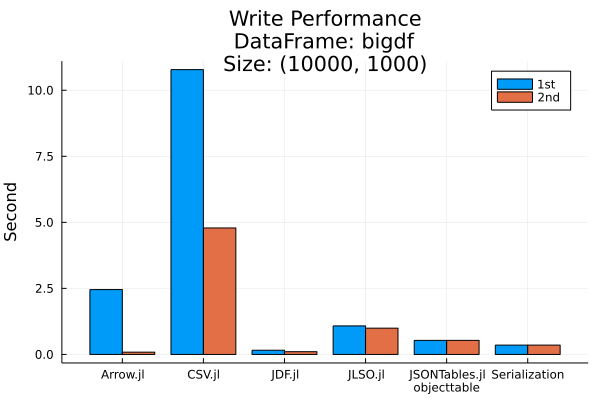

In [38]:
groupedbar(
    # Exclude JSONTables.jl arraytable due to timing
    repeat(["CSV.jl", "Serialization", "JDF.jl", "JLSO.jl", "Arrow.jl", "JSONTables.jl\nobjecttable"],
            inner = 2),
    [csvwrite1, csvwrite2, serializewrite1, serializewrite1, jdfwrite1, jdfwrite2,
     jlsowrite1, jlsowrite2, arrowwrite1, arrowwrite2, jsontablesowrite2, jsontablesowrite2],
    group = repeat(["1st", "2nd"], outer = 6),
    ylab = "Second",
    title = "Write Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

In [39]:
data_files = ["bigdf1.csv", "bigdf.bin", "bigdf.arrow", "bigdf1.json", "bigdf2.json"]
df = DataFrame(file = data_files, size = getfield.(stat.(data_files), :size))
append!(df, DataFrame(file = "bigdf.jdf", size=reduce((x,y)->x+y.size,
                                                      stat.(joinpath.("bigdf.jdf", readdir("bigdf.jdf"))),
                                                      init=0)))
sort!(df, :size)

,file,size
,String,Int64
1,bigdf.arrow,1742834
2,bigdf.bin,5200698
3,bigdf.jdf,5219979
4,bigdf1.csv,55084591
5,bigdf2.json,55088592
6,bigdf1.json,124029699


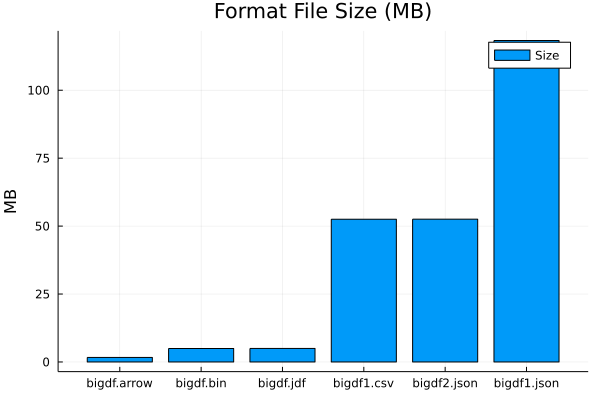

In [40]:
@df df plot(:file, :size/1024^2, seriestype=:bar, title = "Format File Size (MB)", label="Size", ylab="MB")

In [41]:
println("First run")
println("CSV.jl")
csvread1 = @elapsed @time CSV.read("bigdf1.csv", DataFrame)
println("Serialization")
serializeread1 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread1 = @elapsed @time JDF.load("bigdf.jdf") |> DataFrame
println("JLSO.jl")
jlsoread1 = @elapsed @time JLSO.load("bigdf.jlso")
println("Arrow.jl")
arrowread1 = @elapsed @time df_tmp = Arrow.Table("bigdf.arrow") |> DataFrame
arrowread1copy = @elapsed @time copy(df_tmp)
println("JSONTables.jl arraytable")
jsontablesaread1 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread1 = @elapsed @time open(jsontable, "bigdf2.json")
println("Second run")
csvread2 = @elapsed @time CSV.read("bigdf1.csv", DataFrame)
println("Serialization")
serializeread2 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread2 = @elapsed @time JDF.load("bigdf.jdf") |> DataFrame
println("JLSO.jl")
jlsoread2 = @elapsed @time JLSO.load("bigdf.jlso")
println("Arrow.jl")
arrowread2 = @elapsed @time df_tmp = Arrow.Table("bigdf.arrow") |> DataFrame
arrowread2copy = @elapsed @time copy(df_tmp)
println("JSONTables.jl arraytable")
jsontablesaread2 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread2 = @elapsed @time open(jsontable, "bigdf2.json");

First run
CSV.jl
  1.241955 seconds (767.81 k allocations: 77.641 MiB, 2.37% gc time, 38.74% compilation time)
Serialization
  0.509210 seconds (9.49 M allocations: 155.529 MiB, 4.94% gc time, 5.32% compilation time)
JDF.jl
  1.856927 seconds (328.98 k allocations: 170.314 MiB, 1.81% gc time, 92.53% compilation time)
JLSO.jl
  0.355795 seconds (9.51 M allocations: 157.829 MiB, 9.21% gc time, 5.18% compilation time)
Arrow.jl
  0.411612 seconds (488.67 k allocations: 26.124 MiB, 98.09% compilation time)
  0.053611 seconds (12.50 k allocations: 10.358 MiB)
JSONTables.jl arraytable
 11.275657 seconds (240.46 k allocations: 1.338 GiB, 5.86% gc time, 0.00% compilation time)
JSONTables.jl objecttable
  0.472292 seconds (54.19 k allocations: 285.101 MiB, 2.06% gc time, 11.74% compilation time)
Second run
  0.873709 seconds (21.25 k allocations: 32.630 MiB)
Serialization
  0.461200 seconds (9.48 M allocations: 154.666 MiB)
JDF.jl
  0.129120 seconds (67.20 k allocations: 157.911 MiB, 23.15% gc t

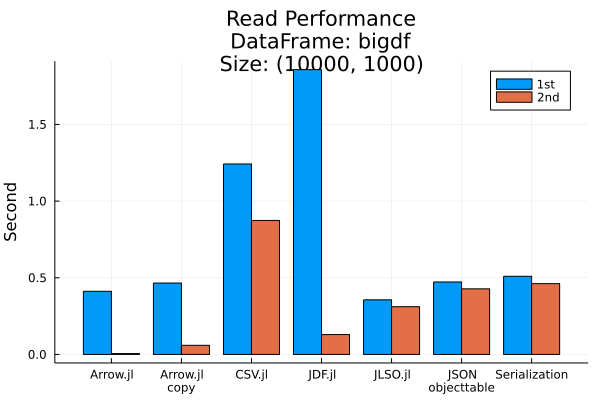

In [42]:
# Exclude JSON\narraytable arraytable due to much longer timing
groupedbar(
    repeat(["CSV.jl", "Serialization", "JDF.jl", "JLSO.jl", "Arrow.jl", "Arrow.jl\ncopy", #"JSON\narraytable",
            "JSON\nobjecttable"], inner = 2),
    [csvread1, csvread2, serializeread1, serializeread2, jdfread1, jdfread2, jlsoread1, jlsoread2,
     arrowread1, arrowread2, arrowread1+arrowread1copy, arrowread2+arrowread2copy,
     # jsontablesaread1, jsontablesaread2,
     jsontablesoread1, jsontablesoread2],    
    group = repeat(["1st", "2nd"], outer = 7),
    ylab = "Second",
    title = "Read Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

## Using gzip compression

A common user requirement is to be able to load and save CSV that are compressed using gzip. Below we show how this can be accomplished using `CodecZlib.jl`. The same pattern is applicable to `JSONTables.jl` compression/decompression.

Again make sure that you do not have file named `df_compress_test.csv.gz` in your working directory.

We first generate a random data frame.

In [43]:
df = DataFrame(rand(1:10, 10, 1000), :auto)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,8,5,7,8,4,2,7,6,9,6,2,8
2,3,5,1,10,3,8,7,2,6,1,2,7
3,6,8,8,4,7,3,8,8,3,10,7,2
4,3,8,10,10,9,5,4,8,9,8,6,9
5,4,4,4,9,6,9,4,3,1,4,10,9
6,3,8,9,4,6,2,4,6,6,8,2,4
7,3,3,2,2,3,1,2,4,4,8,4,5
8,3,2,4,10,5,9,3,3,1,5,6,6
9,6,10,2,3,2,10,8,1,9,5,4,3


In [44]:
# GzipCompressorStream comes from CodecZlib

open("df_compress_test.csv.gz", "w") do io
    stream = GzipCompressorStream(io)
    CSV.write(stream, df)
    close(stream)
end

In [45]:
df2 = CSV.File(transcode(GzipDecompressor, Mmap.mmap("df_compress_test.csv.gz"))) |> DataFrame

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,8,5,7,8,4,2,7,6,9,6,2,8
2,3,5,1,10,3,8,7,2,6,1,2,7
3,6,8,8,4,7,3,8,8,3,10,7,2
4,3,8,10,10,9,5,4,8,9,8,6,9
5,4,4,4,9,6,9,4,3,1,4,10,9
6,3,8,9,4,6,2,4,6,6,8,2,4
7,3,3,2,2,3,1,2,4,4,8,4,5
8,3,2,4,10,5,9,3,3,1,5,6,6
9,6,10,2,3,2,10,8,1,9,5,4,3


In [46]:
df == df2

true

## Using zip files

Sometimes you may have files compressed inside a zip file.

In such a situation you may use [ZipFile.jl](https://github.com/fhs/ZipFile.jl) in conjunction an an appropriate reader to read the files.

Here we first create a ZIP file and then read back its contents into a `DataFrame`.

In [47]:
df1 = DataFrame(rand(1:10, 3, 4), :auto)

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,4,8,1,6
2,5,4,5,1
3,6,7,9,9


In [48]:
df2 = DataFrame(rand(1:10, 3, 4), :auto)

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,6,8,9,8
2,6,9,4,10
3,4,5,10,9


And we show yet another way to write a `DataFrame` into a CSV file

In [49]:
# write a CSV file into the zip file
w = ZipFile.Writer("x.zip")

f1 = ZipFile.addfile(w, "x1.csv")
write(f1, sprint(show, "text/csv", df1))

# write a second CSV file into zip file
f2 = ZipFile.addfile(w, "x2.csv", method=ZipFile.Deflate)
write(f2, sprint(show, "text/csv", df2))

close(w)

Now we read the CSV we have written:

In [50]:
z = ZipFile.Reader("x.zip");

In [51]:
# find the index index of file called x1.csv
index_xcsv = findfirst(x->x.name == "x1.csv", z.files)
# to read the x1.csv file in the zip file
df1_2 = CSV.read(read(z.files[index_xcsv]), DataFrame)

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,4,8,1,6
2,5,4,5,1
3,6,7,9,9


In [52]:
df1_2 == df1

true

In [53]:
# find the index index of file called x2.csv
index_xcsv = findfirst(x->x.name == "x2.csv", z.files)
# to read the x2.csv file in the zip file
df2_2 = CSV.read(read(z.files[index_xcsv]), DataFrame)

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,6,8,9,8
2,6,9,4,10
3,4,5,10,9


In [54]:
df2_2 == df2

true

Note that once you read a given file from `z` object its stream is all used-up (it is at its end). Therefore to read it again you need to close `z` and open it again.

Also do not forget to close the zip file once done.

In [55]:
close(z)

Finally, let's clean up. Do not run the next cell unless you are sure that it will not erase your important files.

In [56]:
foreach(rm, ["x1.csv", "x.bin", "x.jlso", "x1.json", "x2.json",
             "bigdf1.csv", "bigdf.bin", "bigdf.jlso", "bigdf1.json", "bigdf2.json", 
             "x.zip"])

In [57]:
rm("bigdf.jdf", recursive=true)
rm("x.jdf", recursive=true)

Note that we did not remove `x.arrow` and `bigdf.arrow` and `df_compress_test.csv.gz` - you have to do it manually, as these files are memory mapped.